## Simulate release recaputure

18 November 2025

Santi

In [1]:
# import two_atom_interaction.py
from two_atom_interaction import *
# keep track of time
import time

### Na

In [2]:
pixel_to_um = 0.87  # microns per pixel
# set a single detuning value (far away from interaction) and sweep the pulse time (rabi frequency) of atom 1
cfg = ExperimentConfig(
    R_mean_um = 6.0 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 0.0,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg

    t_pi_atom1_us = 1.0, # pulse time for atom 1 (us)

    Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (1.0, 1.0, 1.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 500,  # number of Monte Carlo samples per detuning
    N_steps = 100,  # number of time steps in evolution
    load_depth_T_atom1 = 1000, # uK
    load_depth_T_atom2 = 100, # uK
    plot_displacements = False,  # whether to plot displacement histogram
    
    # simulate recapture for atom 1 only (Na)
    simulate_atom1_recapture=True,
    simulate_atom2_recapture=False,

    hamiltonian_on=False # only simulate recapture without Hamiltonian evolution
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

if True:
    # print experiment configurations for reference
    print("Experiment Configuration:")
    for field_name, field_value in cfg.__dict__.items():
        print(f"  {field_name}: {field_value}")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Experiment Configuration:
  atom1: <arc.alkali_atom_data.Sodium object at 0x107b8f250>
  mass_atom1: 3.81754100782179e-26
  n_atom1: 51
  l_atom1: 0
  j_atom1: 0.5
  m1: 0.5
  OMEGA_atom1_Hz: 0.0
  T2_atom1_s: 5e-06
  wavelength_nm_atom1: 616.0
  atom2: <arc.alkali_atom_data.Cesium object at 0x107b8f110>
  mass_atom2: 2.206946954537107e-25
  n_atom2: 54
  l_atom2: 0
  j_atom2: 0.5
  m2: 0.5
  OMEGA_atom2_Hz: 0
  T2_atom2_s: 2e-05
  wavelength_nm_atom2: 1064.0
  R_mean_um: 5.22
  R_axis_um: (1.0, 0.0, 0.0)
  t_pi_atom1_us: 1.0
  t_wait_s: 0.0
  T1_use_ARC: True
  T_uK_atom1: (1.0, 1.0, 1.0)
  T_uK_atom2: (1.0, 1.0, 1.0)
  omega_trap_atom1_Hz: (230000.0, 230000.0, 37000.0)
  omega_trap_atom2_Hz: (100000.0, 100000.0, 20000.0)
  load_depth_T_atom1: 1000
  load_depth_T_atom2: 100
  load_factor: 0.31622776601683794
  squeeze_factor: (1.0, 

In [3]:
# sweep over pulse times (Rabi frequencies)
pulse_times_us_Na = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us_Na)))
# rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us_Na * 1e-6)))  # in Hz
pop_array_Na = []
for pulse_time, color in zip(pulse_times_us_Na, colors):
    cfg.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Na.append(P_int[0])  # only one detuning point

    if False:
        # plot histogram of potential + kinetic energy of atom 1 (Na)
        plt.figure(figsize=(8,5))
        ke = np.array([i[0] for i in cfg.energy_array1])
        u = np.array([i[1] for i in cfg.energy_array1])
        pot = np.array([i[2] for i in cfg.energy_array1])[0]
        plt.hist(ke + u, bins=50, alpha=0.7, label='Total Energy')
        plt.hist(ke, bins=50, alpha=0.7, label='Kinetic Energy')
        plt.hist(u, bins=50, alpha=0.7, label='Potential Energy')

        # plot vertical line at trap depth
        plt.axvline(pot, color='r', linestyle='--', label='Trap Depth')
        plt.xlabel("Total Energy of Na atom (Joules)")
        plt.ylabel("Counts")
        plt.title(f"Na Energy Distribution after π pulse @ t_pi={pulse_time:.1f} μs")
        plt.legend()
        plt.tight_layout()
        plt.show()

Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

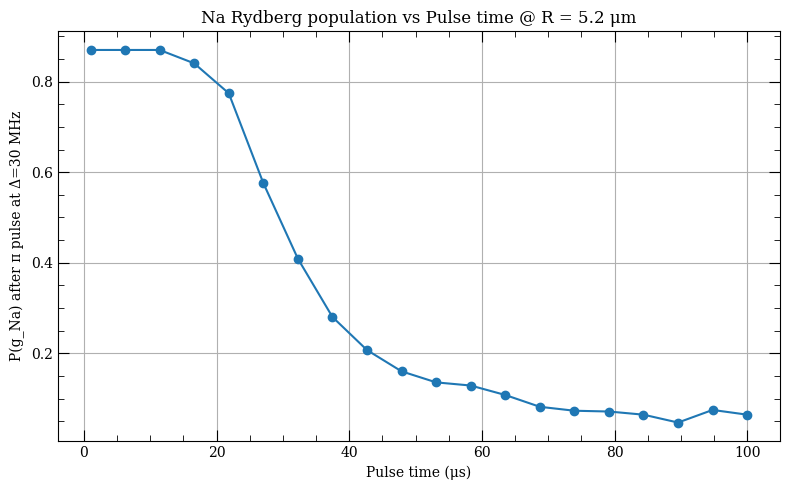

In [4]:
# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us_Na, np.array(pop_array_Na)*0.87, "o-")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Na) after π pulse at Δ=30 MHz")
plt.title(f"Na Rydberg population vs Pulse time @ R = {cfg.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.grid()
plt.tight_layout()
plt.show()

### For Cs

In [5]:
pixel_to_um = 0.67 # imaging system calibration from Cs-Cs (Na-Cs gives ~ 0.87)
# set a single detuning value (far away from interaction) and sweep the pulse time (rabi frequency) of atom 1
cfg = ExperimentConfig(
    R_mean_um = 6.0 * pixel_to_um,  # mean interatomic distance in microns
    R_axis_um = (1.0, 0.0, 0.0),  # along x-axis
    OMEGA_atom1_Hz = 0.0,  # Na Rabi frequency (Hz)
    OMEGA_atom2_Hz = 0,  # Cs Rabi frequency (Hz) [no Cs drive] - just prepare Cs in Rydberg
    t_pi_atom1_us=1.0, # pulse time for atom 1 (us)
    
    Delta_scan_Hz = np.array([1e6]), # single detuning value (Hz)

    # Order: (x, y, z). (radial, radial, axial)
    # These are the *ground-state* trap temps of each tweezer. (uK)
    T_uK_atom1 = (1.0, 1.0, 1.0), # 2.0
    T_uK_atom2 = (1.0, 1.0, 1.0), # 1.0

    # These are the *ground-state* trap frequencies of each tweezer. (loading depth)
    omega_trap_atom1_Hz = (230e3, 230e3, 37e3), # using values from ryan 29Oct
    omega_trap_atom2_Hz = (100e3, 100e3, 20e3),

    load_factor = np.sqrt(0.1),#np.sqrt(0.01),  # % of trap depth after dropping

    T2_atom1_s = 5e-6, # coherence time for Na
    T2_atom2_s = 20e-6, # coherence time for Cs
    T1_use_ARC = True, # whether to use ARC lifetimes for T1

    broadening = True, # turn on or off broadening
    N_mc = 500,  # number of Monte Carlo samples per detuning
    N_steps = 100,  # number of time steps in evolution
    load_depth_T_atom1 = 1000, # uK
    load_depth_T_atom2 = 100, # uK
    plot_displacements = False,  # whether to plot displacement histogram

    # simulate recapture for atom 2 only (Cs)
    simulate_atom1_recapture=False,
    simulate_atom2_recapture=True,

    hamiltonian_on = False # only simulate recapture without Hamiltonian evolution
)

start_time = time.time()
# Compute C6 once (ARC)
c6 = compute_c6_atom1_atom2_rad_per_s_um6(cfg, progress=True)
print(f"C6 (Na 51S - Cs 54S) = {c6:.3e} rad/s·μm^6")
print("C6 (Na 51S - Cs 54S) = %.3f GHz·μm^6" % (c6 / (2*np.pi*1e9)))
print(f"time for C6 calculation: {time.time() - start_time:.1f} s")

if True:
    # print experiment configurations for reference
    print("Experiment Configuration:")
    for field_name, field_value in cfg.__dict__.items():
        print(f"  {field_name}: {field_value}")

Computed C6: -37.57467761041112 GHz·μm^6
C6 (Na 51S - Cs 54S) = 2.361e+11 rad/s·μm^6
C6 (Na 51S - Cs 54S) = 37.575 GHz·μm^6
time for C6 calculation: 0.1 s
Experiment Configuration:
  atom1: <arc.alkali_atom_data.Sodium object at 0x17d1ad310>
  mass_atom1: 3.81754100782179e-26
  n_atom1: 51
  l_atom1: 0
  j_atom1: 0.5
  m1: 0.5
  OMEGA_atom1_Hz: 0.0
  T2_atom1_s: 5e-06
  wavelength_nm_atom1: 616.0
  atom2: <arc.alkali_atom_data.Cesium object at 0x17d1ad450>
  mass_atom2: 2.206946954537107e-25
  n_atom2: 54
  l_atom2: 0
  j_atom2: 0.5
  m2: 0.5
  OMEGA_atom2_Hz: 0
  T2_atom2_s: 2e-05
  wavelength_nm_atom2: 1064.0
  R_mean_um: 4.0200000000000005
  R_axis_um: (1.0, 0.0, 0.0)
  t_pi_atom1_us: 1.0
  t_wait_s: 0.0
  T1_use_ARC: True
  T_uK_atom1: (1.0, 1.0, 1.0)
  T_uK_atom2: (1.0, 1.0, 1.0)
  omega_trap_atom1_Hz: (230000.0, 230000.0, 37000.0)
  omega_trap_atom2_Hz: (100000.0, 100000.0, 20000.0)
  load_depth_T_atom1: 1000
  load_depth_T_atom2: 100
  load_factor: 0.31622776601683794
  squeeze_

In [6]:
# sweep over pulse times (Rabi frequencies)
pulse_times_us_Cs = np.linspace(1, 100, 20)  # in microseconds
colors = plt.cm.viridis(np.linspace(0, 1, len(pulse_times_us_Cs)))
rabi_freqs_Hz = (np.pi / (2 * (pulse_times_us_Cs * 1e-6)))  # in Hz
pop_array_Cs = []
pos_array_Cs = []
vel_array_Cs = []
for pulse_time, color in zip(pulse_times_us_Cs, colors):
    cfg.t_pi_atom1_us = pulse_time

    # run simulation here
    start_time = time.time()
    
    # (A) with interaction + broadening
    start_time = time.time()
    d, P_int = scan_detuning(cfg, c6_rad_um6=c6, interaction_on=True)
    print(f"time for (A) with interaction: {time.time() - start_time:.1f} s")

    pop_array_Cs.append(P_int[0])  # only one detuning point

    if False:
        # plot histogram of potential + kinetic energy of atom 2 (Cs)
        plt.figure(figsize=(8,5))
        ke = np.array([i[0] for i in cfg.energy_array2])
        u = np.array([i[1] for i in cfg.energy_array2])
        pot = np.array([i[2] for i in cfg.energy_array2])[0]
        plt.hist(ke + u, bins=50, alpha=0.7, label='Total Energy')
        plt.hist(ke, bins=50, alpha=0.7, label='Kinetic Energy')
        plt.hist(u, bins=50, alpha=0.7, label='Potential Energy')

        # plot vertical line at trap depth
        plt.axvline(pot, color='r', linestyle='--', label='Trap Depth')
        plt.xlabel("Total Energy of Cs atom (Joules)")
        plt.ylabel("Counts")
        plt.title(f"Cs Energy Distribution after π pulse @ t_pi={pulse_time:.1f} μs")
        plt.legend()
        plt.tight_layout()
        plt.show()

#    # plot final position
#     final_positions = np.array(cfg.positions2_list) + np.array(cfg.velocities2_list)*pulse_time*1e-6  # in microns
#     plt.figure(figsize=(8,5))
#     plt.hist(final_positions[:,0], bins=50, alpha=0.7)
#     plt.xlabel("Final Position of Cs atom (μm) x-axis")
#     plt.ylabel("Counts")
#     plt.title(f"Cs Final Position Distribution after π pulse @ t_pi={pulse_time:.1f} μs")
#     plt.tight_layout()
#     plt.show()
#     plt.figure(figsize=(8,5))
#     plt.hist(final_positions[:,1], bins=50, alpha=0.7)
#     plt.xlabel("Final Position of Cs atom (μm) y-axis")
#     plt.ylabel("Counts")
#     plt.title(f"Cs Final Position Distribution after π pulse @ t_pi={pulse_time:.1f} μs")
#     plt.tight_layout()
#     plt.show()
#     plt.figure(figsize=(8,5))
#     plt.hist(final_positions[:,2], bins=50, alpha=0.7)
#     plt.xlabel("Final Position of Cs atom (μm) z-axis")
#     plt.ylabel("Counts")
#     plt.title(f"Cs Final Position Distribution after π pulse @ t_pi={pulse_time:.1f} μs")
#     plt.tight_layout()
#     plt.show()

    # # plot n values for Cs (atom 2)
    # plt.figure(figsize=(8,5))
    # plt.hist(np.array(cfg.n_list)[:,1][:,0], bins=50, alpha=0.7)
    # plt.xlabel("n of Cs atom")
    # plt.ylabel("Counts")
    # plt.title(f"Cs n Distribution after π pulse @ t_pi={pulse_time:.1f} μs - x-axis")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(8,5))
    # plt.hist(np.array(cfg.n_list)[:,1][:,1], bins=50, alpha=0.7)
    # plt.xlabel("n of Cs atom")
    # plt.ylabel("Counts")
    # plt.title(f"Cs n Distribution after π pulse @ t_pi={pulse_time:.1f} μs - y-axis")
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(8,5))
    # plt.hist(np.array(cfg.n_list)[:,1][:,2], bins=50, alpha=0.7)
    # plt.xlabel("n of Cs atom")
    # plt.ylabel("Counts")
    # plt.title(f"Cs n Distribution after π pulse @ t_pi={pulse_time:.1f} μs - z-axis")
    # plt.tight_layout()
    # plt.show()


Starting detuning scan...
time for (A) with interaction: 0.1 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction: 0.0 s
Starting detuning scan...
time for (A) with interaction

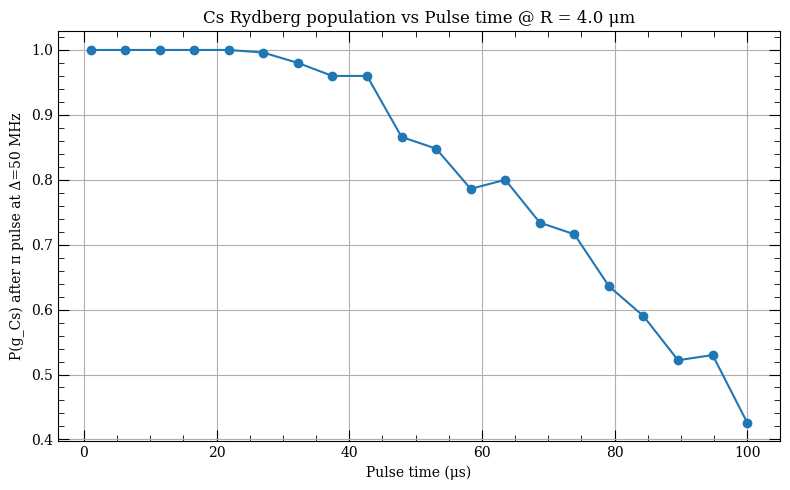

In [7]:
# plot pulse time vs population
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us_Cs, pop_array_Cs, "o-")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g_Cs) after π pulse at Δ=50 MHz")
plt.title(f"Cs Rydberg population vs Pulse time @ R = {cfg.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
plt.grid()
plt.tight_layout()
plt.show()

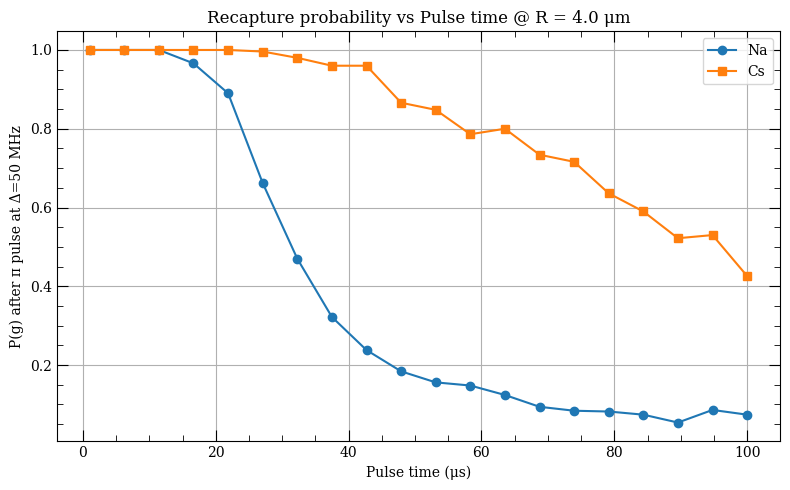

In [8]:
# plot both Na and Cs populations together
plt.figure(figsize=(8,5))
plt.plot(pulse_times_us_Na, pop_array_Na, "o-", label="Na")
plt.plot(pulse_times_us_Cs, pop_array_Cs, "s-", label="Cs")
plt.xlabel("Pulse time (μs)")
plt.ylabel("P(g) after π pulse at Δ=50 MHz")
plt.title(f"Recapture probability vs Pulse time @ R = {cfg.R_mean_um:.1f} μm")
# set x-axis to log scale
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()